In [64]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

GBIF.org (04 November 2024) GBIF Occurrence Download  https://doi.org/10.15468/dl.s8gc9c

(4)  A species richness map is a spatial representation that shows the number of different 
species (i.e., species richness) present in specific geographic areas by counting the 
unique species observed within that area. It highlights the distribution of biodiversity 
across a landscape by depicting where higher or lower concentrations of species occur. 

Your task is to create a bird species richness map for Kenya. Your map should provide a 
clear visual representation of the geographic distribution of bird diversity and offer 
insights into potential biodiversity hotspots or areas of lower species richness. After 
doing so, analyze how bird species richness varies across the country. 

In [65]:
# Load the dataset
df = pd.read_csv('/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')
df.shape

/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_86482/2616293513.py:2: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/mina/Desktop/MADS/3rd_semester/WorkshopI/geospatial-data-analysis/data/GBIT_annotated_archive/DARWIN_CORE_ARCHIVE/0020723-241024112534372/occurrence.txt', delimiter='\t')


(89632, 223)

In [66]:
df.columns

Index(['gbifID', 'accessRights', 'bibliographicCitation', 'language',
       'license', 'modified', 'publisher', 'references', 'rightsHolder',
       'type',
       ...
       'publishedByGbifRegion', 'level0Gid', 'level0Name', 'level1Gid',
       'level1Name', 'level2Gid', 'level2Name', 'level3Gid', 'level3Name',
       'iucnRedListCategory'],
      dtype='object', length=223)


`scientificName`: This field will allow us to count unique species (like Accipiter badius) in each geographic region to determine species richness.

`vernacularName` (common name), which can be helpful for easier interpretation in visualizations.

`decimalLatitude` and `decimalLongitude`: These fields provide precise coordinates, enabling us to map occurrences spatially across Kenya.
    
`eventDate`: Useful if you want to analyze temporal patterns in species richness.

`individualCount`: Not directly required for species richness but may add value if you're also interested in abundance patterns.

`iucnRedListCategory`: Useful for conservation insights, indicating the threat level for observed species. This could help you identify areas with high richness of threatened species.

In [67]:
# Filter records for Kenya and remove any rows with missing lat/lon
df_kenya = df[(df['countryCode'] == 'KE') & df['decimalLatitude'].notna() & df['decimalLongitude'].notna()]
df_kenya.shape

(89632, 223)

In [68]:
print(df_kenya['scientificName'].value_counts())
print("#"*100)
print(df_kenya['vernacularName'].value_counts())
print("#"*100)
print(df_kenya['decimalLatitude'].value_counts())
print("#"*100)
print(df_kenya['decimalLongitude'].value_counts())
print("#"*100)
print(df_kenya['eventDate'].value_counts())
print("#"*100)
print(df_kenya['individualCount'].value_counts())
print("#"*100)
print(df_kenya['iucnRedListCategory'].value_counts())
print("#"*100)

scientificName
Corvus albus Statius Muller, 1776               1605
Pycnonotus barbatus (Desfontaines, 1789)        1601
Bostrychia hagedash (Latham, 1790)              1452
Colius striatus J.F.Gmelin, 1789                1343
Streptopelia capicola (Sundevall, 1857)         1075
                                                ... 
Pterocles quadricinctus Temminck, 1815             1
Ptilostomus afer (Linnaeus, 1766)                  1
Heteromyias albispecularis (Salvadori, 1876)       1
Puffinus bailloni (Bonaparte, 1857)                1
Pycnonotus goiavier (Scopoli, 1786)                1
Name: count, Length: 1256, dtype: int64
####################################################################################################
vernacularName
Common Bulbul                1601
Pied Crow                    1361
Speckled Mousebird           1343
African Pied Wagtail          980
Red-eyed Dove                 965
                             ... 
Southern Black-flycatcher       1
African 

In [69]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_kenya,
    geometry=gpd.points_from_xy(df_kenya['decimalLongitude'], df_kenya['decimalLatitude']),
    crs='EPSG:4326'
)

In [70]:
print(gdf.head())

       gbifID  accessRights  bibliographicCitation  language    license  \
0  1986821111           NaN                    NaN       NaN  CC_BY_4_0   
1  1986821110           NaN                    NaN       NaN  CC_BY_4_0   
2  1986821109           NaN                    NaN       NaN  CC_BY_4_0   
3  1986821108           NaN                    NaN       NaN  CC_BY_4_0   
4  1986821107           NaN                    NaN       NaN  CC_BY_4_0   

   modified  publisher  references  rightsHolder  type  ...  level0Gid  \
0       NaN        NaN         NaN           NaN   NaN  ...        KEN   
1       NaN        NaN         NaN           NaN   NaN  ...        KEN   
2       NaN        NaN         NaN           NaN   NaN  ...        KEN   
3       NaN        NaN         NaN           NaN   NaN  ...        KEN   
4       NaN        NaN         NaN           NaN   NaN  ...        KEN   

   level0Name  level1Gid    level1Name    level2Gid  level2Name  \
0       Kenya   KEN.39_1  Taita Tavet

In [71]:
# Group by location and count unique species
species_richness = gdf.groupby(['decimalLatitude', 'decimalLongitude']).agg({'scientificName': 'nunique'}).reset_index()
species_richness.rename(columns={'scientificName': 'species_count'}, inplace=True)

In [72]:
print(species_richness.head())

   decimalLatitude  decimalLongitude  species_count
0        -4.719087         39.369996              1
1        -4.719030         39.369679              1
2        -4.719009         39.369538              1
3        -4.718704         39.369087              1
4        -4.717096         39.369243              1


In [73]:
# Convert to GeoDataFrame
gdf_richness = gpd.GeoDataFrame(
    species_richness,
    geometry=gpd.points_from_xy(species_richness['decimalLongitude'], species_richness['decimalLatitude']),
    crs='EPSG:4326'
)

In [74]:
print(gdf_richness.head())

   decimalLatitude  decimalLongitude  species_count                   geometry
0        -4.719087         39.369996              1     POINT (39.37 -4.71909)
1        -4.719030         39.369679              1  POINT (39.36968 -4.71903)
2        -4.719009         39.369538              1  POINT (39.36954 -4.71901)
3        -4.718704         39.369087              1   POINT (39.36909 -4.7187)
4        -4.717096         39.369243              1   POINT (39.36924 -4.7171)


/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


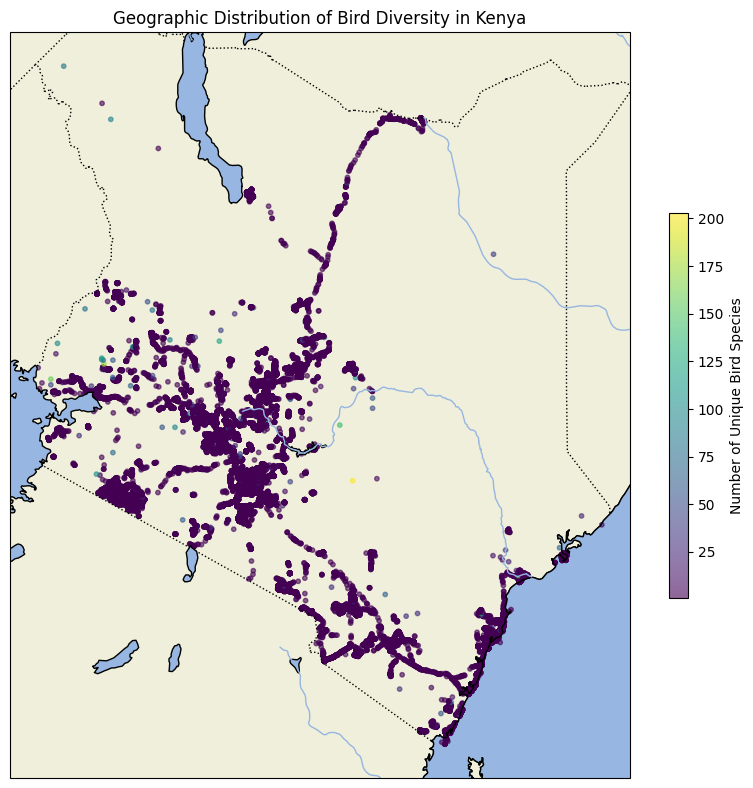

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)


# Plot species richness data as points with color intensity based on richness
scatter = ax.scatter(
    gdf_richness['decimalLongitude'],
    gdf_richness['decimalLatitude'],
    c=gdf_richness['species_count'],
    cmap='viridis',
    s=10,
    transform=ccrs.PlateCarree(),
    alpha=0.6
)


# Add a colorbar to indicate species richness levels
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Number of Unique Bird Species')

# Set title and axis labels
ax.set_title('Geographic Distribution of Bird Diversity in Kenya')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
